### Data Analysis on Multi-family Low-rise Buildings in NYC - Manhattan Community Board 3

In [1]:
import numpy as np
import pandas as pd
import math

from numpy import mean, std, cov, sqrt, log, sum
from numpy.random import seed

from datetime import date, timedelta, datetime

from random import sample

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from matplotlib_venn import venn2

import json
import requests
from bs4 import BeautifulSoup

from  scrapy.http import Request
from scrapy.selector import Selector
from scrapy.http import HtmlResponse

from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from tabulate import tabulate

from geopy.geocoders import Nominatim

import warnings
warnings.filterwarnings('ignore')

# style.use('fivethirtyeight')

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 1000)

rand_state=1000

### Import Data

#### The basic information of buildings in Manhattan Community Board 3 are from Pluto Data Dictionary from new york city public databases.

The information might be incomplete. An alternative way is to ask for information from new york city's office or Community Board 3.

In [2]:
## https://www1.nyc.gov/assets/planning/download/pdf/data-maps/open-data/pluto_datadictionary.pdf?v=22v1
raw_pluto=pd.read_csv('data/pluto_22v1.csv')

# building class codes
raw_buildingclass=pd.read_csv('data/buildingclasscode.csv')

# owner type codes
raw_ownertype=pd.read_csv('data/ownertype.csv')

# DOB permit issurance
raw_dob=pd.read_csv('data/DOB_Permit_Issuance.csv')

### Data merging and cleansing

In [3]:
## imputate yearbuilt of value 0
pluto=raw_pluto[(raw_pluto['landuse'].isin([2,3])) &
         (raw_pluto['cd']==303.0) &
         (raw_pluto['bldgdepth']<75)]

pluto=pluto[['bbl','yearbuilt','lot','ownertype', 'ownername',
             'bldgclass','address','assesstot','exempttot', 
             'latitude', 'longitude', 'unitstotal']]
pluto['bbl'] = pluto['bbl'].round().apply(int).apply(str)

pluto=pluto.merge(raw_buildingclass, left_on='bldgclass', right_on='id', how='left').drop('id',axis=1)

def replace_missing(val, probs):
    if (np.isnan(val)) | (val<=1):
        return np.random.choice(probs.index, p = probs)
    else:
        return val
    
for col in ["yearbuilt"]:
    unique_p = pluto[col].value_counts(normalize = True)
    pluto[col] = pluto[col].apply(replace_missing, args = (unique_p,))

## change ownertype to Private('P') if it is NaN 
pluto['ownertype'].fillna('P', inplace=True)
pluto=pluto.merge(raw_ownertype, left_on='ownertype', right_on='id', how='left').drop('id',axis=1)

## calculate property values, ages, taxes etc
pluto['property_value']=pluto['assesstot']-pluto['exempttot']
pluto['age']=date.today().year-pluto['yearbuilt']
pluto['tax_rate']=np.where(pluto['unitstotal']<=3, 0.19963, 0.12235)
pluto['tax']=pluto['property_value']*pluto['tax_rate']

## get building's full address from latitude and longitude
geolocator = Nominatim(user_agent="geoapiExercises")
pluto['latitude'] = pluto['latitude'].astype(str)
pluto['longitude'] = pluto['longitude'].astype(str)
pluto['location']=pluto.apply(lambda x: geolocator.reverse(x.latitude+","+x.longitude), axis=1)
pluto['fulladdress']=pluto.apply(lambda x: x.location.raw['address'].get('house_number','') + ' ' +\
        x.location.raw['address'].get('road','') + ','+ \
        x.location.raw['address'].get('suburb','') + ','  + \
        x.location.raw['address'].get('state','') , axis=1).str.upper()
pluto['House #']=pluto.apply(lambda x: x.location.raw['address'].get('house_number',''), axis=1)
pluto['Street Name']=pluto.apply(lambda x: x.location.raw['address'].get('road',''), axis=1).str.upper()
pluto['Suburb']=pluto.apply(lambda x: x.location.raw['address'].get('suburb',''), axis=1).str.upper()
pluto['Zip Code']=pluto.apply(lambda x: x.location.raw['address'].get('postcode',''), axis=1)
df_pluto=pluto.copy()
## Rent control/stabilized, Co-op, Condo
# - In general, rent stabilized buildings:
# - Contain 6 or more units;
# - Were built before 1974;
# - Are not co-ops or condos;

# In this analysis, these conditions above are supposed to 
# be all inclusive to define a rent control/stabilized building

pluto['rent_stabilization']=np.where((pluto['unitstotal']>=6) 
                                     & (pluto['yearbuilt']<1974)
                                     & ~pluto['bldgclass'].str.startswith('R'), 'Rent Stabilization',pluto['building_class'] )

## energy source from department of building
dob=raw_dob[raw_dob['Community Board']=='303']
dob=dob[['House #', 'Street Name', 'Zip Code','Oil Gas']].drop_duplicates(subset=['House #', 'Street Name', 'Zip Code'])
dob['Zip Code']=dob['Zip Code'].apply(int).apply(str)
pluto=pluto.merge(dob, on=['House #', 'Street Name', 'Zip Code'], how='left')
pluto=pluto.rename(columns={"Oil Gas": "Energy(DOB)"})

In [44]:
df=dob[['House #','Oil Gas']].groupby('Oil Gas').count()
df

,House #
Oil Gas,
GAS,1
OIL,14


In [47]:
print('There are '+str(len(dob))+' unique buildings of community board 3 in DOB database.')
print('Within these buildings, only '+str(df['House #'][0])+' building with Gas equipment recorded.')
print('Within these buildings, only '+str(df['House #'][1])+' building with Oil equipment recorded.')

There are 1475 unique buildings of community board 3 in DOB database.
Within these buildings, only 1 building with Gas equipment recorded.
Within these buildings, only 14 building with Oil equipment recorded.


### The datasets with partial required fields

In [4]:
data=pluto[['fulladdress', 'age', 'ownername', 
            'property_value', 'unitstotal', 'bldgclass',
            'building_class', 'ownertype','owner_type', 'rent_stabilization',
            'tax','Energy(DOB)']]
data=data.rename(columns={"tax": "tax_calculated"})
data.head(50)

,fulladdress,age,ownername,property_value,unitstotal,bldgclass,building_class,ownertype,owner_type,rent_stabilization,tax_calculated,Energy(DOB)
0,"351 FRANKLIN AVENUE,BROOKLYN,NEW YORK",10.0,55-27 MYRTLE AVE REALTY GROUP LLC,789300.0,10.0,D1,ELEVATOR APARTMENTS: Semi-fireproof (Without S...,P,Private ownership,ELEVATOR APARTMENTS: Semi-fireproof (Without S...,96570.85500,NaN
1,"429 MONROE STREET,BROOKLYN,NEW YORK",16.0,"PASTUIZACA, LUIS",74640.0,3.0,C0,WALK UP APARTMENTS: Three Families,P,Private ownership,WALK UP APARTMENTS: Three Families,14900.38320,NaN
2,"682 HALSEY STREET,BROOKLYN,NEW YORK",123.0,"SMITHSIMON, GREGORY",81240.0,3.0,C0,WALK UP APARTMENTS: Three Families,P,Private ownership,WALK UP APARTMENTS: Three Families,16217.94120,NaN
3,"5 PULASKI STREET,BROOKLYN,NEW YORK",107.0,"MALIK, MOSHE SHIMON",76740.0,3.0,C0,WALK UP APARTMENTS: Three Families,P,Private ownership,WALK UP APARTMENTS: Three Families,15319.60620,NaN
4,"18 MACDONOUGH STREET,BROOKLYN,NEW YORK",123.0,"NOVELO, CLAUDIA",103860.0,3.0,C0,WALK UP APARTMENTS: Three Families,P,Private ownership,WALK UP APARTMENTS: Three Families,20733.57180,NaN
5,"110 MADISON STREET,BROOKLYN,NEW YORK",117.0,"WILLIAMS, CHARLENE",105540.0,3.0,C0,WALK UP APARTMENTS: Three Families,P,Private ownership,WALK UP APARTMENTS: Three Families,21068.95020,NaN
6,"47 HART STREET,BROOKLYN,NEW YORK",123.0,MYRTLE G SPARKS,95280.0,3.0,C0,WALK UP APARTMENTS: Three Families,P,Private ownership,WALK UP APARTMENTS: Three Families,19020.74640,NaN
7,"21 VERNON AVENUE,BROOKLYN,NEW YORK",123.0,DAVID TUBIAN,96300.0,3.0,C0,WALK UP APARTMENTS: Three Families,P,Private ownership,WALK UP APARTMENTS: Three Families,19224.36900,NaN
8,"316 THROOP AVENUE,BROOKLYN,NEW YORK",17.0,AVON APARTMENTS LLC,92460.0,3.0,C0,WALK UP APARTMENTS: Three Families,P,Private ownership,WALK UP APARTMENTS: Three Families,18457.78980,NaN
9,"643 MADISON STREET,BROOKLYN,NEW YORK",7.0,MADISON PARK ESTATES LLC,19462.0,6.0,C2,WALK UP APARTMENTS: Five to Six Families,P,Private ownership,WALK UP APARTMENTS: Five to Six Families,2381.17570,NaN


### Question 1: How many multi-family low-rise buildings are sited in NYC - Manhattan Community Board 3?

- 6106

In [5]:
print('The number of low rise multiple family buildings in Manhattan Community Board 3 is :', len(pluto))

The number of low rise multiple family buildings in Manhattan Community Board 3 is : 6106


Text(0.5, 1.0, 'Low rise multi-family buildings in Manhattan CB 3')

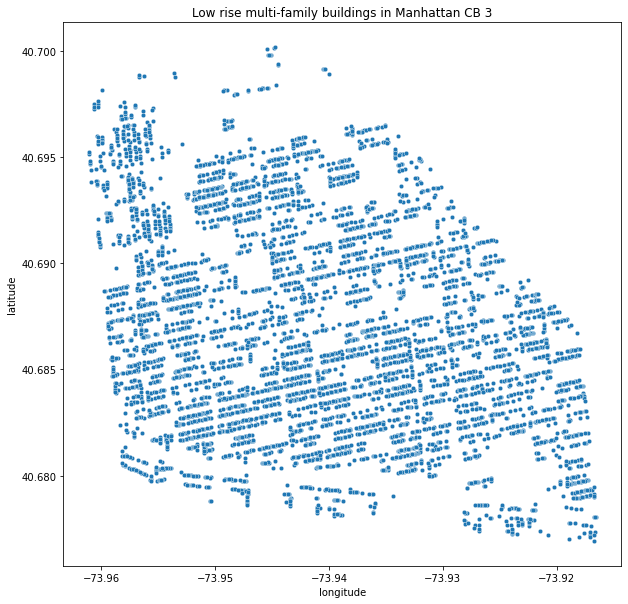

In [6]:
plt.figure(figsize=(10,10))
sns.scatterplot(x=pluto['longitude'].apply(float), 
                y=pluto['latitude'].apply(float), s=20)
plt.title('Low rise multi-family buildings in Manhattan CB 3')

### Question 2: Building Age

In [7]:
pluto[['bbl','yearbuilt','age']].sort_values(by='age')

,bbl,yearbuilt,age
4459,3018220101,2021.0,1.0
3468,3015570038,2021.0,1.0
1336,3018060030,2021.0,1.0
5238,3017750059,2021.0,1.0
3875,3016420006,2021.0,1.0
...,...,...,...
4348,3018520053,1872.0,150.0
4098,3016790037,1871.0,151.0
2343,3018180037,1871.0,151.0
868,3018520012,1863.0,159.0


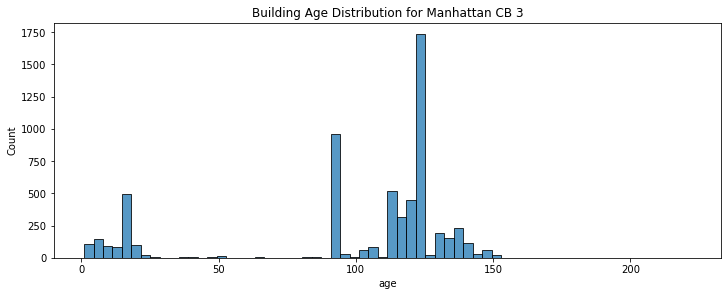

In [8]:
df=pluto[['bbl', 'age']]
fig = plt.figure(constrained_layout=True, figsize=(10,4))
ax=sns.histplot(x="age", data=df)
plt.title('Building Age Distribution for Manhattan CB 3')
plt.show()

Text(0.5, 1.0, 'Low rise multi-family buildings in Manhattan CB 3 (by Age)')

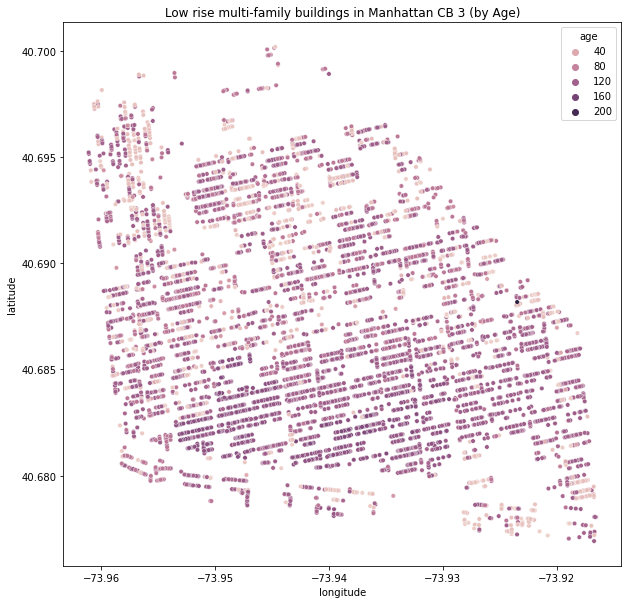

In [9]:
plt.figure(figsize=(10,10))
sns.scatterplot(x=pluto['longitude'].apply(float), 
                y=pluto['latitude'].apply(float), hue=pluto['age'], s=20)
plt.title('Low rise multi-family buildings in Manhattan CB 3 (by Age)')

###  Question 2: Property taxes

In [10]:
pluto[['bbl','assesstot','exempttot','property_value','tax']].sort_values(by='property_value')

,bbl,assesstot,exempttot,property_value,tax
908,3017600053,161100.0,161100.0,0.0,0.00000
605,3016470019,315000.0,315000.0,0.0,0.00000
3401,3016510045,92160.0,92160.0,0.0,0.00000
4422,3018150014,432450.0,432450.0,0.0,0.00000
5479,3020170001,270450.0,270450.0,0.0,0.00000
...,...,...,...,...,...
2101,3017780089,3347100.0,0.0,3347100.0,409517.68500
1880,3019940007,3666150.0,0.0,3666150.0,448553.45250
47,3019247501,5579559.0,9840.0,5569719.0,681455.11965
3929,3016330060,6010200.0,0.0,6010200.0,735347.97000


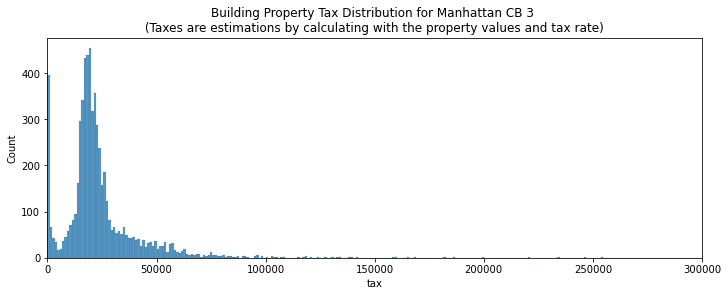

In [11]:
df=pluto[['bbl', 'tax']]
fig = plt.figure(constrained_layout=True, figsize=(10,4))
ax=sns.histplot(x="tax", data=df)
plt.title('Building Property Tax Distribution for Manhattan CB 3 \n (Taxes are estimations by calculating with the property values and tax rate) ')
plt.xlim([-50, 300000])
plt.show()

Text(0.5, 1.0, 'Low rise multi-family buildings in Manhattan CB 3 (by Tax)')

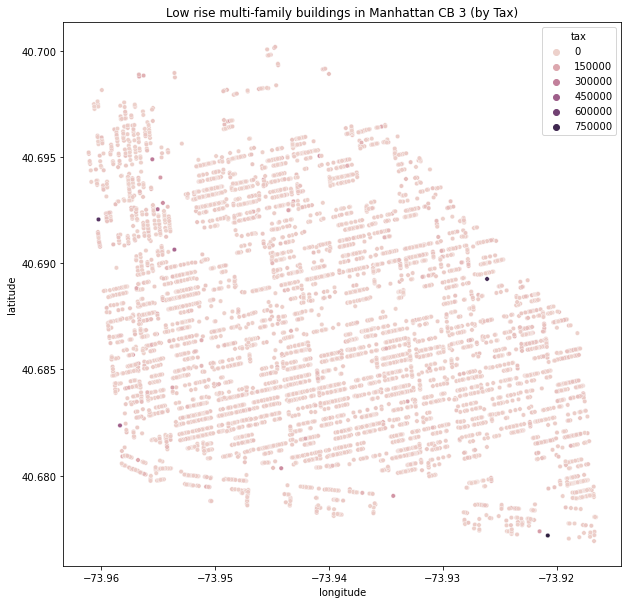

In [12]:
plt.figure(figsize=(10,10))
sns.scatterplot(x=pluto['longitude'].apply(float), 
                y=pluto['latitude'].apply(float), hue=pluto['tax'], s=20)
plt.title('Low rise multi-family buildings in Manhattan CB 3 (by Tax)')

### Ownership

In [26]:
pluto[['bbl','ownername', 'ownertype', 'owner_type']]

,bbl,ownername,ownertype,owner_type
0,3019680005,55-27 MYRTLE AVE REALTY GROUP LLC,P,Private ownership
1,3018160056,"PASTUIZACA, LUIS",P,Private ownership
2,3016670041,"SMITHSIMON, GREGORY",P,Private ownership
3,3017700095,"MALIK, MOSHE SHIMON",P,Private ownership
4,3018540009,"NOVELO, CLAUDIA",P,Private ownership
...,...,...,...,...
6101,3019740019,"THORPE, PAUL",P,Private ownership
6102,3019490007,UNAVAILABLE OWNER,P,Private ownership
6103,3017620026,BEDFORD REALTY HOLDINGS LLC,P,Private ownership
6104,3017130016,"RALPH-GATES CLUSTER, L.P.",X,Fully tax-exempt property that may be owned by...


### Question 2: Public or Private

In [27]:
pluto[['address', 'ownertype', 'owner_type']].head(20)

,address,ownertype,owner_type
0,351 FRANKLIN AVENUE,P,Private ownership
1,429 MONROE STREET,P,Private ownership
2,682 HALSEY STREET,P,Private ownership
3,5 PULASKI STREET,P,Private ownership
4,18 MAC DONOUGH STREET,P,Private ownership
5,110 MADISON STREET,P,Private ownership
6,47 HART STREET,P,Private ownership
7,21 VERNON AVENUE,P,Private ownership
8,316 THROOP AVENUE,P,Private ownership
9,643 MADISON STREET,P,Private ownership


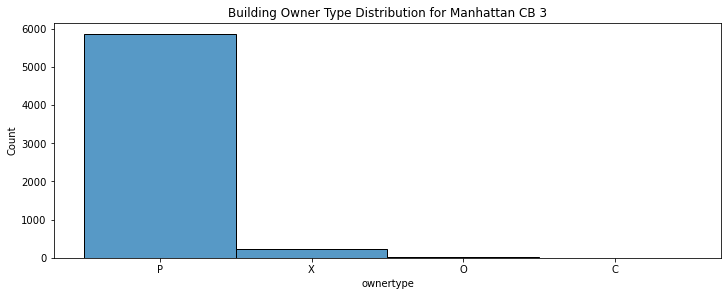

In [28]:
df=pluto[['address', 'ownertype']]
fig = plt.figure(constrained_layout=True, figsize=(10,4))
ax=sns.histplot(x="ownertype", data=df)
plt.title('Building Owner Type Distribution for Manhattan CB 3')
plt.show()

(-50.0, 3000000.0)

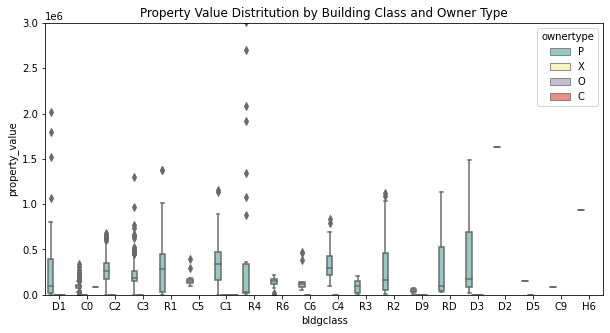

In [29]:
plt.figure(figsize=(10,5))

sns.boxplot(x="bldgclass", y="property_value", hue="ownertype",
                 data=pluto, palette="Set3")
plt.title('Property Value Distritution by Building Class and Owner Type')
plt.ylim(-50, 3000000)

(-50.0, 300000.0)

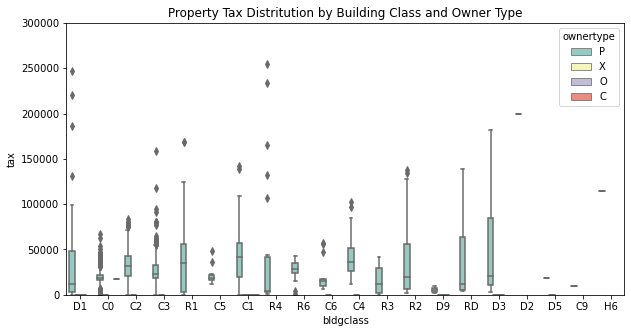

In [30]:
plt.figure(figsize=(10,5))

sns.boxplot(x="bldgclass", y="tax", hue="ownertype",
                 data=pluto, palette="Set3")
plt.title('Property Tax Distritution by Building Class and Owner Type')
plt.ylim(-50, 300000)

Text(0.5, 1.0, 'Low rise multi-family building counts by Building Class and Owner Type')

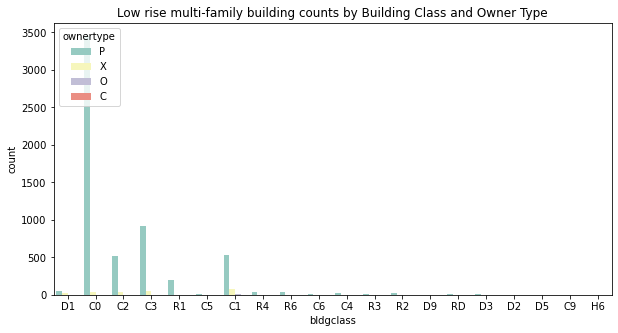

In [31]:
plt.figure(figsize=(10,5))

sns.countplot(x="bldgclass", hue="ownertype",
                 data=pluto, palette="Set3")
plt.title('Low rise multi-family building counts by Building Class and Owner Type')

Text(0.5, 1.0, 'Low rise multi-family buildings in Manhattan CB 3 (by Owner type)')

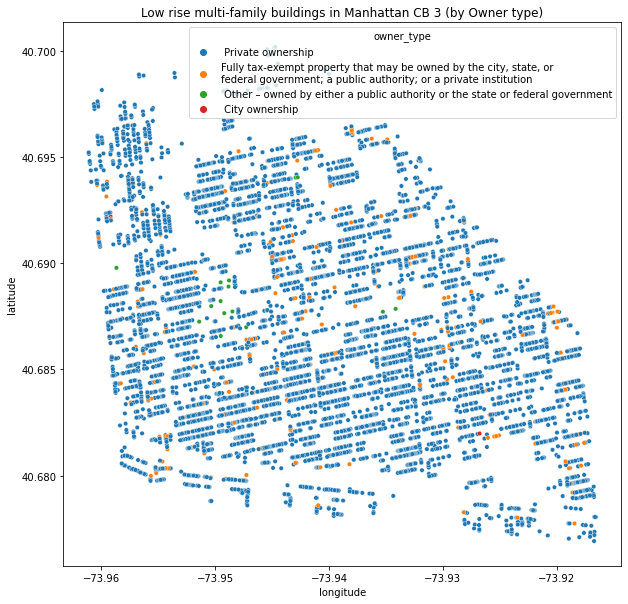

In [32]:
plt.figure(figsize=(10,10))
sns.scatterplot(x=pluto['longitude'].apply(float), 
                y=pluto['latitude'].apply(float), hue=pluto['owner_type'], s=20)
plt.title('Low rise multi-family buildings in Manhattan CB 3 (by Owner type)')

### Question 2: Market Rental and Energy Source

- the data are scraped from Zillow, seems zillow doesn't want people to scrape their data. So just a dozen of buidlings' information were scraped before captcha stopped the process.

In [36]:
def getproperties(prop, field):
    result=[]
    if field in prop:
        result= prop[field]
    return result
    
baseURL='https://www.zillow.com/homes/'

df=pd.DataFrame()
notdone=pd.DataFrame()
block=0

for i in range(len(pluto)):
# for i in range(1):
    url=baseURL+pluto['fulladdress'][i].replace(' ','-')+'_rb'
    
    isGetlist=False
    
    zpid=''
    address=''
    price=0
    rental=0
    latest_tax=0
    heating='None'
    
    headers ={
        'authority': 'app.mybodygallery.com',
        'method': 'GET',
        'path': '/classes/Photo?where=%7B%22gender%22:%22female%22,%22status%22:%22APPROVED%22,%22weight%22:%7B%22$gte%22:47,%22$lte%22:53%7D%7D',
        'scheme': 'https',
        'accept': 'application/json, text/plain, */*',
        'accept-encoding': 'gzip, deflate, br',
        'accept-language': 'en-GB,en-US;q=0.9,en;q=0.8',
        'cache-control': 'no-cache',
        'pragma': 'no-cache',
        'referer': url,
        'sec-ch-ua': '" Not;A Brand";v="99", "Google Chrome";v="91", "Chromium";v="91"',
        'sec-ch-ua-mobile': '?1',
        'sec-fetch-dest': 'empty',
        'sec-fetch-mode': 'cors',
        'sec-fetch-site': 'same-origin',
        'user-agent': 'Mozilla/5.0 (Linux; Android 5.0; SM-G900P Build/LRX21T) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Mobile Safari/537.36'
    }

#     headers={"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:98.0) Gecko/20100101 Firefox/98.0",
#     "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,*/*;q=0.8",
#     "Accept-Language": "en-US,en;q=0.5",
#     "Accept-Encoding": "gzip, deflate",
#     "Connection": "keep-alive",
#     "Upgrade-Insecure-Requests": "1",
#     "Sec-Fetch-Dest": "document",
#     "Sec-Fetch-Mode": "navigate",
#     "Sec-Fetch-Site": "none",
#     "Sec-Fetch-User": "?1",
#     "Cache-Control": "max-age=0",}
    
    content = requests.get(url,headers=headers)  
    soup = BeautifulSoup(content.text,"lxml")    
    
    item = soup.select_one("script#hdpApolloPreloadedData")    
    if item==None:
        print(url)
#         print('not data for whole building')
        d=soup.select_one("script#__NEXT_DATA__")
        if d==None:  
            print(url)
#             print('not data for sub-units')
#             driver = webdriver.Chrome(executable_path='C:/chromedriver/chromedriver.exe',options=options)
#             driver.get(url)
#             soup = BeautifulSoup(driver.page_source, "html.parser")        
#             item = soup.select_one("script#hdpApolloPreloadedData")
#             driver.close()  
            notdone.append(pluto.iloc[i])
            isGetlist=True
        else:    
            item = json.loads(soup.select_one("script#__NEXT_DATA__").text)['props']
            properties=item['initialData']['building']
            zpid= getproperties(properties,"zpid")
            address = getproperties(properties,"fullAddress")
            units=getproperties(properties,"ungroupedUnits")
            price=0
            if (units != []) | (units != None):
                for u in units:
                    if (getproperties(u,"price")!=[]) & (getproperties(u,"price")!=None):
                        price=price+getproperties(u,"price")
            rental    = 0              
            latest_tax=0     
            heating='None'
            isGetlist=True
            
    if not isGetlist:
        d = json.loads(item.text)['apiCache']
        data=json.loads(d)
        
        key1 = list(data.keys())[0]
        key2 = list(data.keys())[1]        
        
        properties1 = data[key1]["property"]
        properties2 = data[key2]["property"]

        zpid = getproperties(properties1,"zpid")
        
        address = getproperties(properties1,"streetAddress")+', ' \
            +getproperties(properties1,"city")+', ' \
            +getproperties(properties1,"state")+' ' \
            +getproperties(properties1,"zipcode")
        
        price = getproperties(properties1,"price")
        rental     = getproperties(properties1,"zestimate") 
        latest_tax=getproperties(properties2,"taxHistory")
        if latest_tax !=[]:
            latest_tax=latest_tax[0]['value']      
        heating='None'
        
        facts=[]
        resoFacts=getproperties(properties2,"resoFacts")
        if resoFacts !=[]:
            facts=getproperties(resoFacts,"atAGlanceFacts")
         
        for f in facts:
            if f['factLabel']=='Heating':
                heating=f['factValue']
                break
                
    listing={}
    listing['zpid']=zpid
    listing['address']=address
    listing['price']=price
    listing['rental']=rental
    listing['latest_tax']=latest_tax
    listing['heating']=heating
    if zpid=='':
        block=block+1
        if block==5:
              break;
    else:
        block=0
    
    df=df.append(listing, ignore_index=True)

https://www.zillow.com/homes/351-FRANKLIN-AVENUE,BROOKLYN,NEW-YORK_rb
https://www.zillow.com/homes/682-HALSEY-STREET,BROOKLYN,NEW-YORK_rb
https://www.zillow.com/homes/316-THROOP-AVENUE,BROOKLYN,NEW-YORK_rb
https://www.zillow.com/homes/643-MADISON-STREET,BROOKLYN,NEW-YORK_rb
https://www.zillow.com/homes/53-TAAFFE-PLACE,BROOKLYN,NEW-YORK_rb
https://www.zillow.com/homes/537-THROOP-AVENUE,BROOKLYN,NEW-YORK_rb
https://www.zillow.com/homes/460-MADISON-STREET,BROOKLYN,NEW-YORK_rb
https://www.zillow.com/homes/213-HALSEY-STREET,BROOKLYN,NEW-YORK_rb
https://www.zillow.com/homes/67-LEWIS-AVENUE,BROOKLYN,NEW-YORK_rb
https://www.zillow.com/homes/778-PUTNAM-AVENUE,BROOKLYN,NEW-YORK_rb
https://www.zillow.com/homes/780-PUTNAM-AVENUE,BROOKLYN,NEW-YORK_rb
https://www.zillow.com/homes/601-MARCY-AVENUE,BROOKLYN,NEW-YORK_rb
https://www.zillow.com/homes/674-HANCOCK-STREET,BROOKLYN,NEW-YORK_rb
https://www.zillow.com/homes/12-SPENCER-PLACE,BROOKLYN,NEW-YORK_rb
https://www.zillow.com/homes/12-SPENCER-PLACE,BRO

#### the Market Rental and Energy information scraped before blocked by zillow

In [37]:
df

,zpid,address,price,rental,latest_tax,heating
0,2080394018,"351 Franklin Ave, Brooklyn, NY 11238",7418200.0,0.0,0.0,None
1,72700182,"429 Monroe St, Brooklyn, NY 11221",1591000.0,4795.0,83400.0,None
2,30605179,"682 Halsey St, Brooklyn, NY 11233",1462000.0,0.0,0.0,None
3,30607563,"5 Pulaski St, Brooklyn, NY 11206",830000.0,2400.0,70980.0,None
4,30611157,"184 Macdonough St, Brooklyn, NY 11216",2423000.0,[],132900.0,None
5,30628185,"1108 Madison St, Brooklyn, NY 11221",1680700.0,4283,84060.0,"Baseboard, Gas"
6,83048473,"471 Hart St, Brooklyn, NY 11221",1667200.0,[],108000.0,None
7,30607072,"217 Vernon Ave, Brooklyn, NY 11206",1403800.0,[],74880.0,None
8,83049783,"316 Throop Ave, Brooklyn, NY 11206",842500.0,0,0.0,None
9,30603750,"643 Madison St, Brooklyn, NY 11221",10648200.0,0,0.0,None


#### Fuel Cost and emission information from the new york city public database are limited. Department of Building's DOB Permit Issuance dataset has partial oil or gas data for buildings, but no cost and emission information.